# Example Segmentation: inferior fronto-occipital fasciculus (IFOF)

NOTE:  This segmentation is taken almost verbatim from a [recent version of the matlab-version of WMA segmentation](https://github.com/DanNBullock/wma_tools/blob/53a4d99b68b832257c55d5f1320dc7266cc8c270/Segmentations/bsc_segmentAntPostTracts_v4.m#L322-L500)

## Loading the requisite data

As with the previous chapter, we'll begin by loading the relevant data objects.  Note, though, that this time we are using different sets of input streamlines.  This is because the [IFOF](https://en.wikipedia.org/wiki/Occipitofrontal_fasciculus) is a particularly long tract, as it runs the entire ventral extent of the brain.

In [1]:
#this code ensures that we can navigate the WiMSE repo across multiple systems
import subprocess
import os
import pandas as pd
import seaborn as sns
#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#establish path to the 
wma_toolsDirPath=os.path.join(gitRepoPath,'wma_pyTools')   

#change to the wma_tools path, load the function set, then change back to the top directory
os.chdir(wma_toolsDirPath)
import WMA_pyFuncs
os.chdir(gitRepoPath)

import nibabel as nib
import numpy as np

grossAnatomyPath=os.path.join(gitRepoPath,'exampleData','GrossAnatomyLookup.csv')

grossAnatTable=pd.read_csv(grossAnatomyPath)
#load the atlas
atlasPath=os.path.join(gitRepoPath,'exampleData','parc.nii.gz')
#load it as an object
atlasImg = nib.load(atlasPath)

#establish path to t1
t1Path=os.path.join(gitRepoPath,'exampleData','t1.nii.gz')   

#import the data
t1img = nib.load(t1Path)
#done to establish bounds of image in acpc space
fullMask = nib.nifti1.Nifti1Image(np.ones(t1img.get_fdata().shape), t1img.affine, t1img.header)
#pass full mask to boundary function
t1DimBounds=WMA_pyFuncs.returnMaskBoundingBoxVoxelIndexes(fullMask)
#convert the coords to subject space in order set max min values for interactive visualization
convertedBoundCoords=nib.affines.apply_affine(t1img.affine,t1DimBounds)

#get and copy the data
grossAnatAtlas=atlasImg.get_fdata().copy()
#get the labels to iterate over
uniqueAtlasEntries=np.unique(atlasImg.get_fdata()).astype(int)
#get the unique 
grossAnatList=grossAnatTable['GrossAnat'].unique()
#iterate across unique label entries
for iLabels in range(len(uniqueAtlasEntries)):
    #print(np.isin(grossAnatTable['GrossAnat'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]],grossAnatList))
    #replace the current uniqueAtlasEntries value with the label corresponding to the gross anat category
    currentLabelReNum=np.where(np.isin(grossAnatList,grossAnatTable['GrossAnat'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]]))
    grossAnatAtlas[atlasImg.get_fdata()==uniqueAtlasEntries[iLabels]]=currentLabelReNum[0]
#set the gross anatomy nifti
grossAnatNifti=nib.Nifti1Image(grossAnatAtlas, atlasImg.affine, atlasImg.header)  

#now lets do the same thing again but for entire hemispheres
#get and copy the data
hemisphereAtlas=atlasImg.get_fdata().copy()
#get the labels to iterate over
uniqueAtlasEntries=np.unique(atlasImg.get_fdata()).astype(int)
#get the unique 
hemisphereList=grossAnatTable['Hemi'].unique()
#iterate across unique label entries
for iLabels in range(len(uniqueAtlasEntries)):
    #print(np.isin(grossAnatTable['GrossAnat'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]],grossAnatList))
    #replace the current uniqueAtlasEntries value with the label corresponding to the gross anat category
    currentLabelReNum=np.where(np.isin(hemisphereList,grossAnatTable['Hemi'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]]))
    hemisphereAtlas[atlasImg.get_fdata()==uniqueAtlasEntries[iLabels]]=currentLabelReNum[0]
#set the gross anatomy nifti
hemisphereNifti=nib.Nifti1Image(hemisphereAtlas, atlasImg.affine, atlasImg.header)  

# load the tractography file into the streamsObjIN variable
#smallTractogramPath=os.path.join(gitRepoPath,'exampleData','smallTractogram.tck')
TractogramPath1='/Users/plab/Downloads/100to175mmtrack.tck'
TractogramPath2='/Users/plab/Downloads/175to300mmtrack.tck'


streamsObjIN1=nib.streamlines.load(TractogramPath1)
streamsObjIN2=nib.streamlines.load(TractogramPath2)


#get tractogram from the Tck holder
allStreams=np.concatenate((streamsObjIN1.streamlines[:],streamsObjIN2.streamlines[:]))

sourceTractogram= nib.streamlines.tractogram.Tractogram(streamlines=allStreams,affine_to_rasmm=streamsObjIN1.header['voxel_to_rasmm'])


from dipy.tracking import utils
#segment tractome into connectivity matrix from parcellation
M, grouping=utils.connectivity_matrix(sourceTractogram.streamlines, grossAnatNifti.affine, \
                        label_volume=grossAnatNifti.get_fdata().astype(int), \
                        return_mapping=True,\
                        symmetric=False,\
                        mapping_as_streamlines=False)

#segment the tractome into a hemisphere based map (only a 3x3 matrix really)
hemiM, hemiGrouping=utils.connectivity_matrix(sourceTractogram.streamlines, hemisphereNifti.affine, \
                        label_volume=hemisphereNifti.get_fdata().astype(int), \
                        return_mapping=True,\
                        symmetric=False,\
                        mapping_as_streamlines=False)


## Establishing the category

The [inferior fronto-occipital fasciculus (IFOF)](https://en.wikipedia.org/wiki/Occipitofrontal_fasciculus) is definitionally a fronto-occipital tract (hence the name).

Lets visualize the relevant category.

In [2]:
#quick and dirty tractogram subsetter by Brad Caron
#https://github.com/bacaron
def extractSubTractogram(sourceTractogram,indexes):
    #import relevant package
    import nibabel as nib
    #extrect the desired streamlines into a new streamline object
    streamlines = sourceTractogram.streamlines[indexes]
    #establish tractogram object
    out_tractogram = nib.streamlines.tractogram.Tractogram(streamlines)
    #adjust the relevant header fields
    #don't bother for now, header is only relevant to Tck file
    #for headerFields in ['total_count','count','nb_streamlines']:
        #nb_streamlines is an int, whereas the others are strings, for some reason
    #    if headerFields == 'nb_streamlines':
    #        out_tractogram.header[headerFields] = len(streamlines)
    #    else:
    #        out_tractogram.header[headerFields] = '%s' %len(streamlines)
    return out_tractogram

#interactive plotting via niwidgets?  
#widget within a widget doesn't seem to work
def plotParcellationConnectionWidget(subTractogram):
    #import widget
    from niwidgets import StreamlineWidget
    #set widget object
    
    sw = StreamlineWidget(streamlines=subTractogram)
    #set plotting characteristics
    style = {'axes': {'color': 'red',
                  'label': {'color': 'white'},
                  'ticklabel': {'color': 'white'},
                  'visible': False},
         'background-color': 'black',
         'box': {'visible': False}}
    #plot it
    sw.plot(display_fraction=1, width=1000, height=1000, style=style, percentile=0)

def plotTract(tractIn):
    import numpy as np
    from dipy.viz import window, actor
    renderer = window.Scene()
    stream_actor = actor.line(tractIn)
    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #               focal_point=(113.30, 128.31, 76.56),
    #                view_up=(0.18, 0.00, 0.98))
    %matplotlib inline
    renderer.add(stream_actor)
    
    window.show(renderer, size=(600, 600), reset_camera=True)

def updateFunction(regionIndex1,regionIndex2):
    currentRenumberIndex1=regionIndex1    
    currentRenumberIndex2=regionIndex2   
 
    
    #check to make sure this pairing is actually in the connections
    if np.logical_or((currentRenumberIndex1,currentRenumberIndex2) in grouping.keys(),(currentRenumberIndex1,currentRenumberIndex2) in grouping.keys()): 
        #if they are both there do it (dipy method may preclude this)
        if np.logical_and((currentRenumberIndex1,currentRenumberIndex2) in grouping.keys(),(currentRenumberIndex1,currentRenumberIndex2) in grouping.keys()): 
            currentIndexes=np.concatenate((np.asarray(grouping[currentRenumberIndex1,currentRenumberIndex2]),np.asarray(grouping[currentRenumberIndex2,currentRenumberIndex1]))).astype(int)
        elif (currentRenumberIndex1,currentRenumberIndex2) in grouping.keys():
            currentIndexes=grouping[currentRenumberIndex1,currentRenumberIndex2]
        elif (currentRenumberIndex2,currentRenumberIndex1) in grouping.keys():
            currentIndexes=grouping[currentRenumberIndex2,currentRenumberIndex1]
        #there are no other potential cases
        subTractogram=extractSubTractogram(sourceTractogram,currentIndexes)
        %matplotlib inline
        plotParcellationConnectionWidget(subTractogram.streamlines)
    else:
        print('connection not present')

dropDownList=list(zip(grossAnatList, range(len(grossAnatList))))

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Dropdown

#establish interactivity
interact(updateFunction, 
         regionIndex1=Dropdown(options=dropDownList, value=9, description="region1"), 
         regionIndex2=Dropdown(options=dropDownList, value=10, description="region2"),
        )
#create a boolean vector for the category outputs
categoryBool=np.zeros(len(sourceTractogram.streamlines),dtype=int)
leftBool=np.zeros(len(sourceTractogram.streamlines),dtype=int)
rightBool=np.zeros(len(sourceTractogram.streamlines),dtype=int)

categoryBool[np.union1d(grouping[9,10],grouping[10,9])]=True
#1 is left hemisphere, 2 is right, 0 is both/neither/midline
leftBool[hemiGrouping[1,1]]=True
rightBool[hemiGrouping[2,2]]=True

interactive(children=(Dropdown(description='region1', index=9, options=(('unknown', 0), ('wm', 1), ('ventricle…

## Establish more specific endpoint criteria (loosely)

As it turns out, we do not actually need to include additional endpoint criteria for the IFOF given how distinct it is.  The only other streamlines in this category are extremely dorsal to the IFOF candidates, and are most likely associated with the superior longitudinal fasciculus ([SLF](https://en.wikipedia.org/wiki/Superior_longitudinal_fasciculus)) (although there has been some debate as to the existence of a superior fronto-occipital fasciculus, it is currently accepted that no such structure exists in humans ([Liu et al., 2020](https://doi.org/10.1016/j.nicl.2020.102192)).  

As such we can move on to using other anatomical criteria.

## Other anatomical criteria

One of the most characteristic features of the IFOF is the 'dip' that occurs adjacent to the [lenticular nucleus](https://en.wikipedia.org/wiki/Lentiform_nucleus), near the [claustrum](https://en.wikipedia.org/wiki/Claustrum).  Overall, our goal will be to apply an exclusion plane to prevent streamlines from traversing the dorsal portion of the brain's white matter.  In order to enshrine that as a criteria we have to approach it in several steps.

### Lenticular-dip criteria 

#### Lenticular-dip criteria  - segmentation logic
First, we have to specify the rostro-caudal location of where we want to ensure that this dip takes place.  The dip is near to its lowest around the middle (along the rostral-caudal axis) of the lenticular nucleus.  This, as it turns out, is about the anterior border of the thalamus.  Insofar as the dorso-ventral positioning of this feature, the top of the [globus paladus](https://en.wikipedia.org/wiki/Globus_pallidus) can serve as a relatively generous limitation (in that the dip typically occurs inferior to this plane; see pg 204 of Mai, Majtanik, & Paxinos 2016).  Note that, in order to use this combination of anatomical features, we will need to use the sliceROIwithPlane function.
    

[Text(0, 0.5, 'category'),
 None,
 Text(0.5, 0, 'streamline count (log)'),
 Text(0.5, 1.0, 'effect of  Lenticular-dip criteria')]

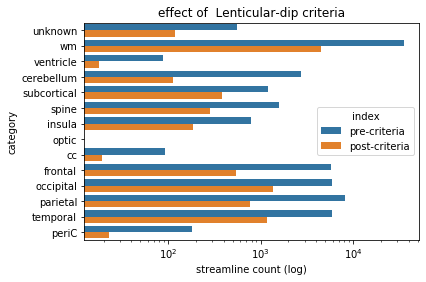

In [3]:
anteriorThalPlane=WMA_pyFuncs.planarROIFromAtlasLabelBorder(atlasImg,10, 'anterior')

superiorPalPlane=WMA_pyFuncs.planarROIFromAtlasLabelBorder(atlasImg,13, 'superior')

excludeVentTractsPlane=WMA_pyFuncs.sliceROIwithPlane(anteriorThalPlane,superiorPalPlane,'inferior') 

GPdipBool=WMA_pyFuncs.applyNiftiCriteriaToTract(sourceTractogram.streamlines, excludeVentTractsPlane, True, 'any')

GPdipLogicMatrix=WMA_pyFuncs.maskMatrixByBoolVec(grouping,GPdipBool)
#sum across columns and make an array
compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(GPdipLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of  Lenticular-dip criteria')

#### Lenticular-dip criteria  - observations

Looking at the above graph, we can note that this criteria had a relatively dramatic effect.  However, given that this was the application of a simple exclusion plane (which we have seen with much less dramatic effect before), we might be curious as to why it achieved this effect.  Remember back to how we loaded particular tractograms earlier, which featured streamlines in excess of 100 mm.  As it turns out, there's a relatively limited number of ways for streamlines to achieve that length, and running the entire rostro-caudal span of the white matter appears to be a fairly common way to do this.  By applying a fairly stringent partial planar criteria (in that only a small portion of the coronal cross-section of the white matter has been spared) along the rostral-caudal axis, we have imposed a strong limitation as where the streamlines can go.  Indeed, this criteria, combined with the categorical requirement, is all that we need to actually segment the IFOF.  As such, we can move on to visualizing the resultant tract.

## Combine criteria and visualize

Below, we will selectively apply the criteria we have created and visualize the output.

Note that, although we can't really see the impact of the lenticular-dip when looking at it on its own, the effect becomes apparent when we look at it in combination with the fronto-occipital category.

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import SelectMultiple

criteriaList=['Lenticular-dip','Category','Right hemisphere','Left hemisphere']

def interpretCriteria(x):
    #might do some weird stuff for equal values
    import numpy as np
    return {
            'Lenticular-dip': GPdipBool,
            'Category': categoryBool,
            'Right hemisphere': rightBool,
            'Left hemisphere': leftBool,
        }[x]

def updateSeg(commandIn):
    import numpy as np
    if len(commandIn)>0:
        criteriaOutArray=np.asarray(list(map(interpretCriteria,commandIn)))
        currentIndexes=np.concatenate(np.where(np.all(criteriaOutArray,axis=0)))
        
        subTractogram=extractSubTractogram(sourceTractogram,currentIndexes)
        %matplotlib inline
        if len(subTractogram.streamlines)>0:
            plotParcellationConnectionWidget(subTractogram.streamlines)
        else:
            print('no streamlines meet specified criteria')

#establish interactivity
interact(updateSeg, commandIn=SelectMultiple(options=criteriaList,value=criteriaList[0:-1], description='criteria',continuous_update=False,disabled=False))



interactive(children=(SelectMultiple(description='criteria', index=(0, 1, 2), options=('Lenticular-dip', 'Cate…

<function __main__.updateSeg(commandIn)>

## Wrapping up

In this chapter we demonstrated how to segment a second white matter structure, the inferior fronto-occipital fasciculus (IFOF).  For now, this concludes the example segmentations we'll provide in this lesson set.  For an example of other possible segmentations to implement as practice check [here](https://github.com/DanNBullock/wma_tools/blob/master/Segmentations/bsc_segmentAntPostTracts_v4.m#L75-L501).  

We'll next move on to some closing thoughts.